In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
from tensorflow import keras

for module in (tf, mpl, np, pd, keras):
    print(module.__name__, module.__version__)

tensorflow 2.0.0-beta1
matplotlib 3.1.0
numpy 1.16.4
pandas 0.24.2
tensorflow.python.keras.api._v2.keras 2.2.4-tf


## Load play datasets

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


## Normalize inputdata by using Sklearn Standscalar

- made x = (x - u) / std

In [3]:
from sklearn.preprocessing import StandardScaler

# before normalization
print(np.max(x_train), np.min(x_train))

# perform normalization
scaler = StandardScaler()
# 1. data in x_train is int32, we need to convert them to float32 first 
# 2. convert x_train data from 
#    [None, 28, 28] -> [None, 784] 
#       -> after all reshape back to [None, 28, 28]
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled  = scaler.transform(x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

# after normalization
print(np.max(x_train_scaled), np.min(x_train_scaled))

255 0
2.0231433 -0.8105136


## Build model with BatchNormalization and Dropout by using tf.keras high level API
<br>
Use keras.layers.BatchNormalization() between to net layers to enable batch normalize data.

### How
In general there are two ways to implement batch normalization
1. direct after convolutional layer (after activation function)
2. before convolutional layer add a additional layer then batch normalization and explicit activation (keras.layers.Activation) is added behind batch normalization
<br>

In order to avoid overfiting problem, is dropout often used in the last few layers. For example you can add 2 - 4 Dropout from 20 layers to reduce training parameters. There are two common Dropout API:
1. keras.layers.Dropout  -> normal dropout could change the distribution of dataset
2. keras.layers.AlphaDropout -> a enhanced version of Dropout with following features...
<br>
    2.1 AlphaDroupout will keep standard deviation and standard variance
    <br>
    2.2 Cause of keeping std-dev and std-var after Dropout. You can combine some operations together alpha-dropout, batch-normalization and activation-function
    <br>
    2.3 It is recommended to set dropout rate to 0.5


In [4]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))

for _ in range(10):
    model.add(keras.layers.Dense(100, activation = "relu"))
    model.add(keras.layers.BatchNormalization())
    '''
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(activation = "relu"))
    '''
model.add(keras.layers.AlphaDropout(rate = 0.5))
model.add(keras.layers.Dense(10, activation = "softmax"))

# if y is one_hot vector then use categorical_crossentropy as loss function
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

## Train model with callback

In [5]:
# Tensorboard, EarlyStopping, ModelCheckPoint
# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks

logdir = './dnn_batch_norm_dropout' # logdir for tensorboard logdata
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")    

callbacks = [
    keras.callbacks.TensorBoard(log_dir=logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    keras.callbacks.EarlyStopping(patience = 5, min_delta = 1e-3)
]

history = model.fit(x = x_train_scaled, y = y_train, epochs = 10, 
                    validation_data = (x_valid_scaled, y_valid),
                    callbacks = callbacks)

# once training is finished, you can use tensorboard to visualize results
# tensorboard --logdir=callbacks

W0703 09:44:00.609814 140315510544192 deprecation.py:323] From /home/bai/.virtualenvs/tensorflow2/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 8s 153us/sample - loss: 1.1005 - accuracy: 0.6430 - val_loss: 0.6294 - val_accuracy: 0.8222
Epoch 2/10
55000/55000 [==============================] - 6s 111us/sample - loss: 0.6956 - accuracy: 0.7771 - val_loss: 0.6000 - val_accuracy: 0.8464
Epoch 3/10
55000/55000 [==============================] - 6s 114us/sample - loss: 0.6029 - accuracy: 0.8083 - val_loss: 0.5662 - val_accuracy: 0.8574
Epoch 4/10
55000/55000 [==============================] - 6s 117us/sample - loss: 0.5463 - accuracy: 0.8244 - val_loss: 0.5289 - val_accuracy: 0.8698
Epoch 5/10
55000/55000 [==============================] - 8s 139us/sample - loss: 0.5007 - accuracy: 0.8383 - val_loss: 0.5406 - val_accuracy: 0.8686
Epoch 6/10
55000/55000 [==============================] - 7s 132us/sample - loss: 0.4751 - accuracy: 0.8460 - val_loss: 0.5336 - val_accuracy: 0.8738
Epoch 7/10
55000/55000 [===========================

## Result visualization

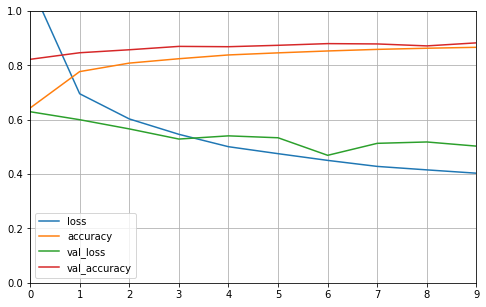

In [6]:
from tensorflow.python.keras.callbacks import History

def plot_learning_curves(history: History):
    pd.DataFrame(history.history).plot(figsize = (8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

## Evaluate model with test dataset

In [7]:
test_loss, test_acc = model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 1s 67us/sample - loss: 0.5558 - accuracy: 0.8699


## Made a simple prediction on test dataset

In [9]:
# one_hot encoded results
predictions = model.predict(x_test)

# compare ml-prediction to test label
for pred_index in range(20):
    print(np.argmax(predictions[pred_index]), y_test[pred_index])

0 9
2 2
6 1
6 1
6 6
6 1
4 4
4 6
1 5
8 7
6 4
6 5
3 7
3 3
2 4
6 1
2 2
2 4
6 8
0 0
